<img src="https://www.seekpng.com/png/detail/33-330419_all-of-your-email-must-be-can-spam.png" width=500/>

# Spam Email Classifier
## In this project we will be building a Machine Learning model that classifies text messages as either spam or ham (regular texts) using a Multinomial Naive Bayes Classifier.
### Data Set Information:

### This corpus has been collected from free or free for research sources at the Internet:

#### -> A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages.
#### -> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link].
#### -> A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis.
#### -> Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages.


## Loading the main libraries

In [1]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [2]:
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
df.shape

(5572, 2)

### There are 5,572 texts/labels in this dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


#### No missing values in the dataset.

# Exploratory Data Analysis

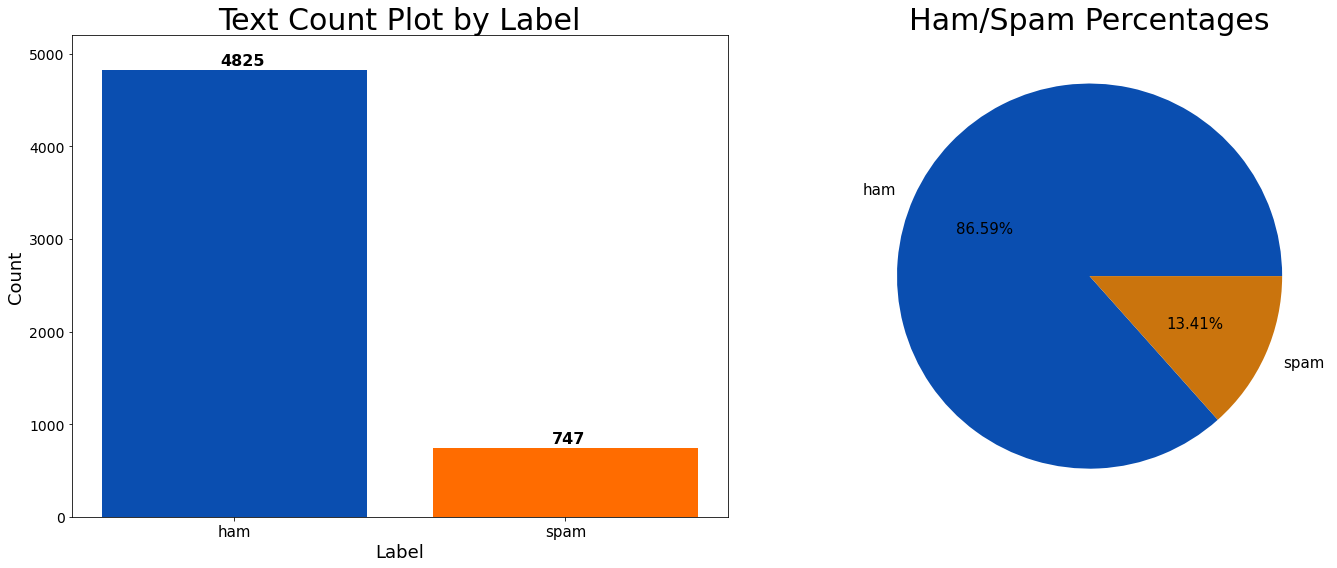

In [5]:
counts = df.label.value_counts()
ham_color = '#0A4EB0'
spam_color = '#FF6C00'
fig, ax = plt.subplots(1, 2, figsize=(20,8))
ax[0].bar(counts.index, counts.values, color=[ham_color, spam_color])
ax[0].set_title('Text Count Plot by Label', fontsize=30)
ax[0].tick_params('x', labelsize=15)
ax[0].tick_params('y', labelsize=14)
ax[0].set_ylim(0, 5200)
ax[0].set_xlabel('Label', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)
for i in range(len(counts)):
    ax[0].text(i-0.04, counts[i]+50, counts[i], fontdict={'fontsize':16, 'fontweight':'bold'})
fig.tight_layout()
ax[1].pie(counts, autopct='%.2f%%', labels=counts.index, textprops={'fontsize':15}, colors=['#0A4EB0', '#CA740D'])
ax[1].set_title('Ham/Spam Percentages', fontsize=30)
plt.show()

### 86% of the texts are regular texts and 13% are spam texts.

# Feature Engineering: Number of Words by Label

## Number of Words per Text

In [6]:
df['num_of_words'] = df.message.apply(lambda x: len(x.split()))
df['num_of_words']

0       20
1        6
2       28
3       11
4       13
        ..
5567    30
5568     8
5569    10
5570    26
5571     6
Name: num_of_words, Length: 5572, dtype: int64

## Mean Number of Words by Label

In [7]:
word_means = df.groupby('label')['num_of_words'].mean()
word_means

label
ham     14.310259
spam    23.911647
Name: num_of_words, dtype: float64

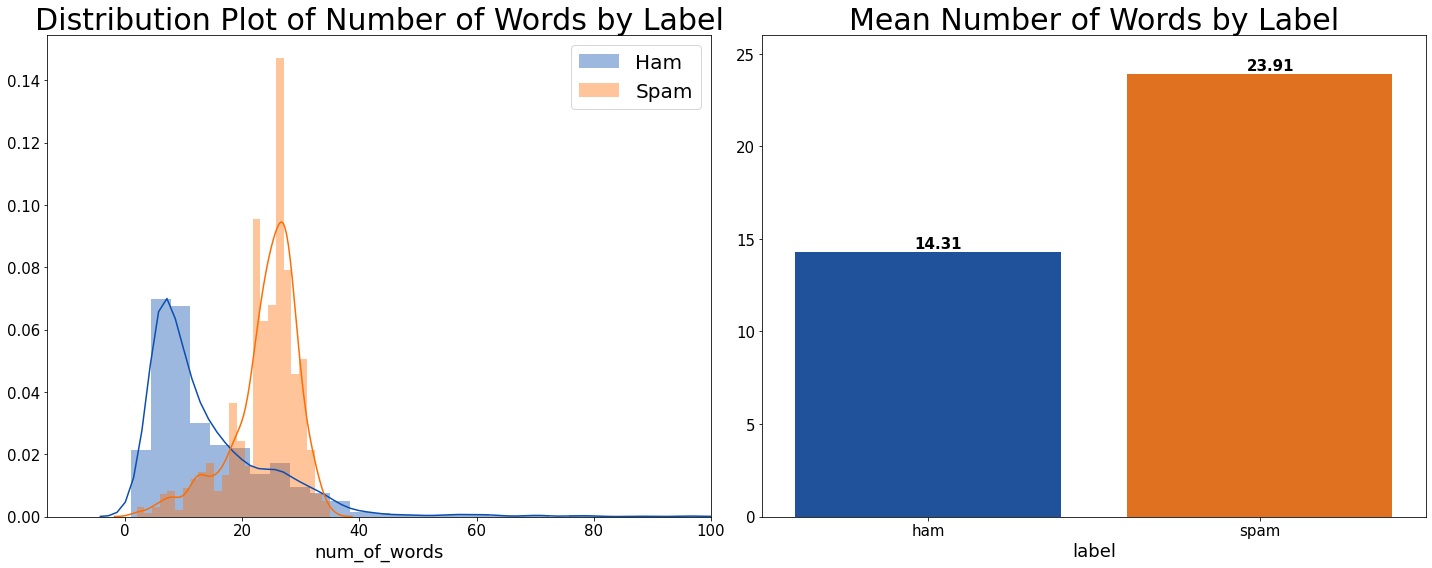

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.distplot(df[df.label == 'ham']['num_of_words'], ax=ax[0], label='Ham', color=ham_color)
sns.distplot(df[df.label == 'spam']['num_of_words'], ax=ax[0], label='Spam', color=spam_color)
ax[0].set_title('Distribution Plot of Number of Words by Label', fontsize=30)
ax[0].legend(fontsize=20)
ax[0].set_xlim(ax[0].get_xlim()[0], 100)
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=18)

sns.barplot(word_means.index, word_means.values, ax=ax[1], palette=[ham_color, spam_color])
ax[1].set_title('Mean Number of Words by Label', fontsize=30)
ax[1].tick_params(labelsize=15)
ax[1].set_xlabel(ax[1].get_xlabel(), fontsize=18)
ax[1].set_ylim(0, 26)
for i in range(len(word_means)):
    ax[1].text(i-0.04, word_means[i]+0.2, round(word_means[i], 2), fontdict={'fontsize':15, 'fontweight':'bold'})
fig.tight_layout()
plt.show()

* ### The ham texts have a right-skewed distribution.
* ### The spam texts have a slight left-skewed distribution.
* ### Spam texts typically contain more words than a regular text.

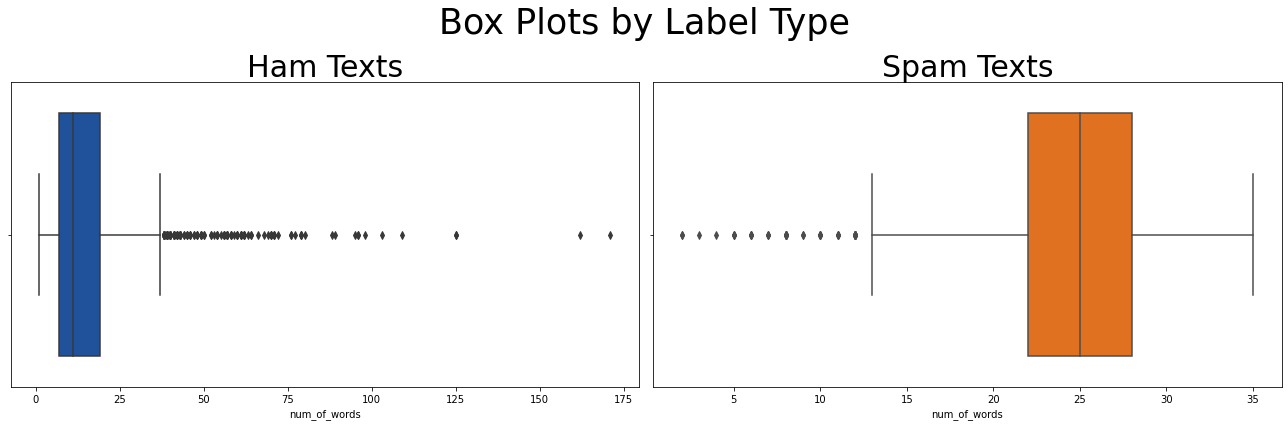

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(df[df.label == 'ham']['num_of_words'], ax=ax[0], color=ham_color)
sns.boxplot(df[df.label == 'spam']['num_of_words'], ax=ax[1], color=spam_color)
ax[0].set_title('Ham Texts', fontsize=30)
ax[1].set_title('Spam Texts', fontsize=30)
fig.suptitle('Box Plots by Label Type', fontsize=35)
fig.tight_layout()
plt.show()

* ### Ham texts have outliers to the right.
* ### Spam texts have outliers to the left.

# Most Common Noun/Verb Phrases by Text Type

In [10]:
ham_np = [] # List for all ham noun phrases
spam_np = [] # List for all spam noun phrases
ham_vp = [] # List for all ham verb phrases
spam_vp = [] # List for all spam verb phrases

# 0 or 1 determiners, 1 or more adjectives, 0 or more conjunctions, 0 or more adjectives, 1 or more nouns
np_parser = nltk.RegexpParser(r"NP: {<DT>?<JJ.?>+<CC>*<JJ.?>*<NN.?.?>+}")
# 0 or more pronouns, 0 or more modals, one verb, 0 or more determiners, 0 or more adjectives, 1 or more nouns
vp_parser = nltk.RegexpParser(r"NP: {<PRP.?>*<MD>*<VB.?><DT>*<JJ.>*<NN.?.?>+}")
for i in range(len(df)):
    tokens = re.sub(r'[^a-zA-Z\'-]', ' ', df['message'][i]).lower().split()
    tokens_pos = nltk.pos_tag(tokens)
    np_result = np_parser.parse(tokens_pos)
    vp_result = vp_parser.parse(tokens_pos)
    for result in np_result:
        if hasattr(result, 'label'):
            if df.iloc[i].label == 'ham':
                ham_np.append(' '.join([word for word, tag in result.leaves()]))
            elif df.iloc[i].label == 'spam':
                spam_np.append(' '.join([word for word, tag in result.leaves()]))
    for result in vp_result:
        if hasattr(result, 'label'):
            if df.iloc[i].label == 'ham':
                ham_vp.append(' '.join([word for word, tag in result.leaves()]))
            elif df.iloc[i].label == 'spam':
                spam_vp.append(' '.join([word for word, tag in result.leaves()]))
            

# Generating Frequencies

In [11]:
ham_np_freq = nltk.probability.FreqDist()
for phrase in ham_np:
    ham_np_freq[phrase] += 1

spam_np_freq = nltk.probability.FreqDist()
for phrase in spam_np:
    spam_np_freq[phrase] += 1
    
ham_vp_freq = nltk.probability.FreqDist()
for phrase in ham_vp:
    ham_vp_freq[phrase] += 1
    
spam_vp_freq = nltk.probability.FreqDist()
for phrase in spam_vp:
    spam_vp_freq[phrase] += 1

# Generating Word Clouds

In [12]:
#!pip install wordcloud

In [13]:
from wordcloud import WordCloud
wc = WordCloud(width=1600, height=800, max_words=300)

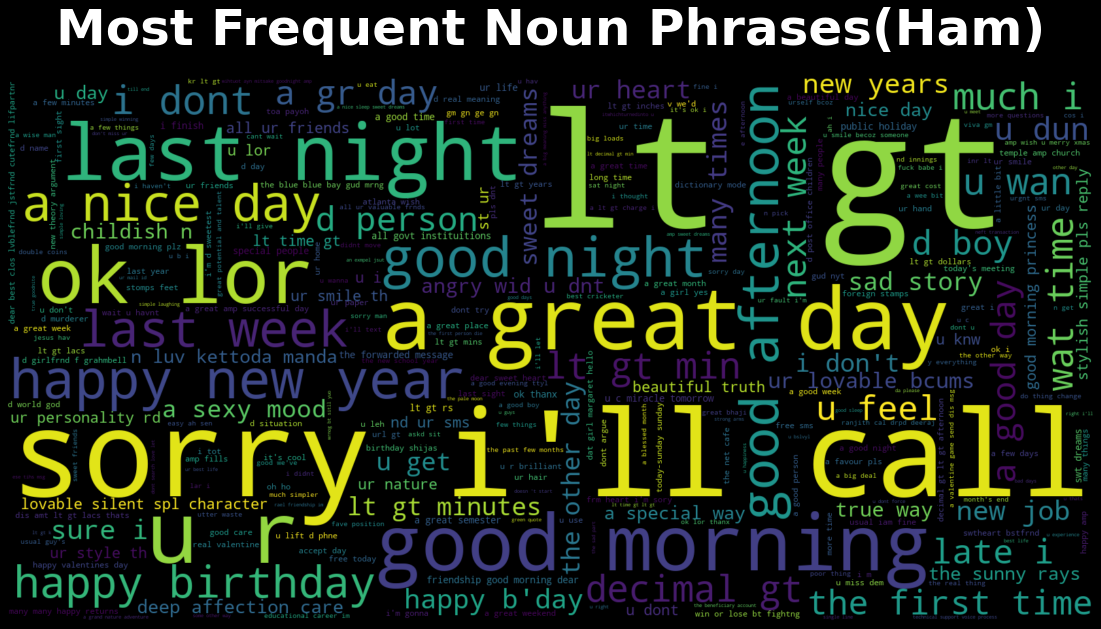

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wc.generate_from_frequencies(ham_np_freq), interpolation='bilinear')
fig.set_facecolor('black')
ax.set_axis_off()
ax.set_title('Most Frequent Noun Phrases(Ham)', fontsize=50, color='white', y=1.05, fontweight='bold')
plt.show()

### The most frequent Ham Noun Phrases tend to express feelings/emotions, eg. "good afternoon", "sorry i'll call", "happy b'day", "[have] a nice/great day", etc.
### They resemble typical everyday texts between friends/relatives.

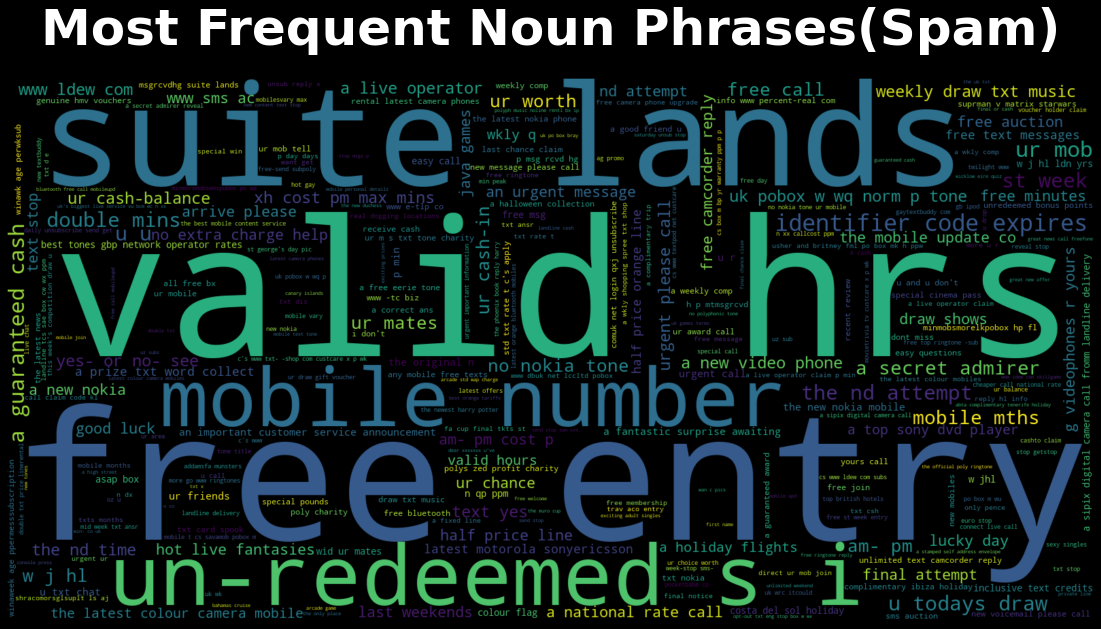

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wc.generate_from_frequencies(spam_np_freq), interpolation='bilinear')
fig.set_facecolor('black')
ax.set_axis_off()
ax.set_title('Most Frequent Noun Phrases(Spam)', fontsize=50, color='white', y=1.05, fontweight='bold')
plt.show()

### The most frequent Spam Noun Phrases are usually about promoting a product/service, eg. "free entry", "a guaranteed cash", "un-redeemed", etc.


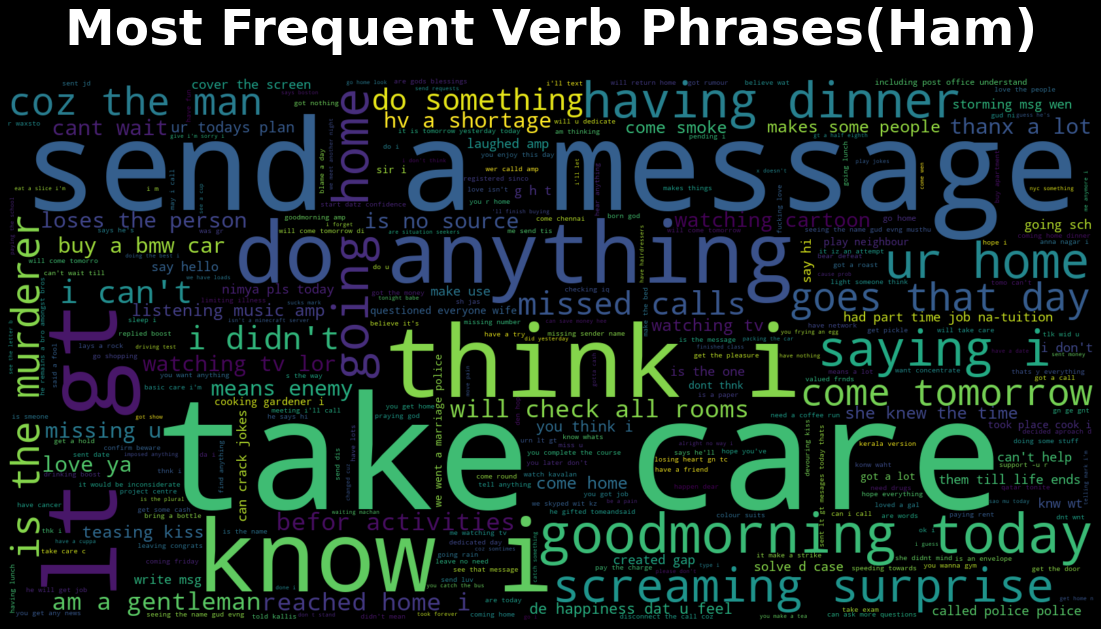

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wc.generate_from_frequencies(ham_vp_freq), interpolation='bilinear')
fig.set_facecolor('black')
ax.set_axis_off()
ax.set_title('Most Frequent Verb Phrases(Ham)', fontsize=50, color='white', y=1.05, fontweight='bold')
plt.show()

### The most frequent Verb Ham Phrases are regular communications between people, eg. "take care", "going home", "having dinner", etc.

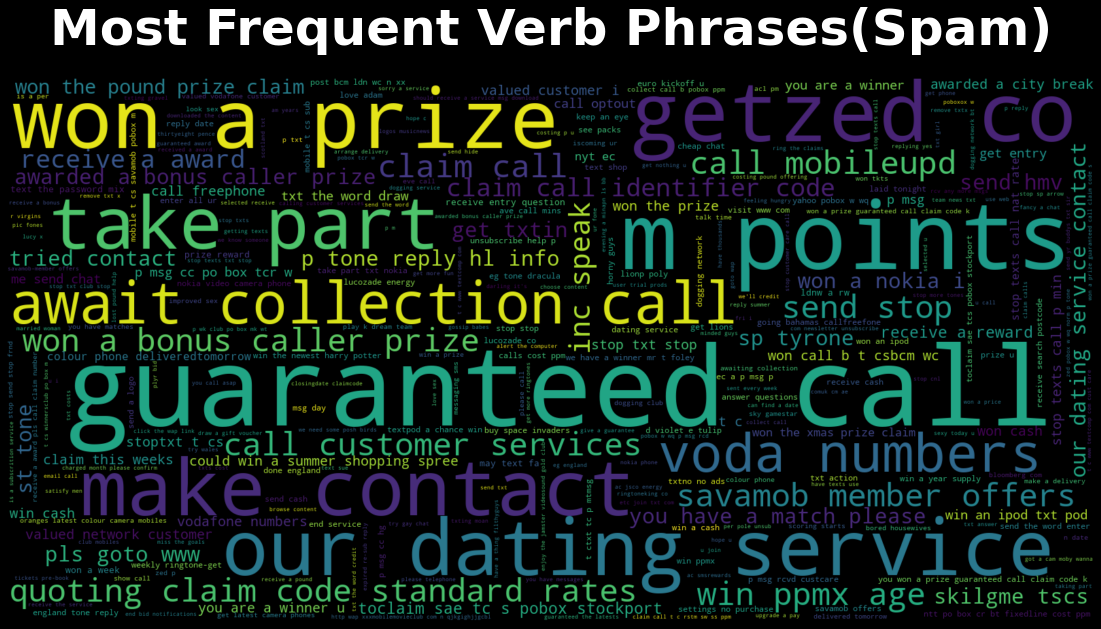

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wc.generate_from_frequencies(spam_vp_freq), interpolation='bilinear')
fig.set_facecolor('black')
ax.set_axis_off()
ax.set_title('Most Frequent Verb Phrases(Spam)', fontsize=50, color='white', y=1.05, fontweight='bold')
plt.show()

### The most frequent Verb Spam Phrases are about selling a product/service, eg. "guaranteed call", "our dating service", "won a prize", etc.

# Tokenizing, Removing Stopwords and Stemming

In [18]:
ps = nltk.stem.PorterStemmer()
corpus = []
for i in range(len(df)):
    # Replacing non-alphabetical characters with a blank space, lowercasing, and splitting the string into a list of words
    message = re.sub(r'[^a-zA-Z]', ' ', df['message'][i]).lower().split() 
    # Stemming each word to its root form
    message = [ps.stem(word) for word in message if word not in nltk.corpus.stopwords.words('english')]
    # Joining the stemmed words back into a string
    message = ' '.join(message)
    # Appending the result to the corpus list
    corpus.append(message)

# Creating the Bag of Words

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000) #Maximum number of words
X = cv.fit_transform(corpus).toarray()
y = df['label'].map({'ham': 0, 'spam': 1}).rename('spam')

In [20]:
print(X)
print(f"\nX.shape: {X.shape}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

X.shape: (5572, 5000)


In [21]:
pd.DataFrame(X, columns=cv.get_feature_names())

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zebra,zed,zero,zf,zhong,zindgi,zoe,zogtoriu,zoom,zouk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### With CountVectorizer, each column is a unique word that appears in the dataset, and each row is a sentence/text, with the values being the amount of times each word appears in that text.

In [22]:
print(y)

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: spam, Length: 5572, dtype: int64


# Creating a Train/Test Split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)
print(f"{'='*27}\nX_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}\n{'='*27}")

X_train.shape: (4457, 5000)
X_test.shape: (1115, 5000)
y_train.shape: (4457,)
y_test.shape: (1115,)


# Training Model Using Naive Bayes Classifier

In [24]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


# Model Accuracy

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
print(f"{'='*60}\n{'-'*60}\nAccuracy (Train Set): {model.score(X_train, y_train)}")
print(f"Accuracy (Test Set): {model.score(X_test, y_test)}\n{'-'*60}\n{'='*60}\n")
print(f"{'='*60}\nClassification Report:\n{'-'*22}\n{classification_report(y_test, y_pred)}\n{'='*60}")
print(f"{'='*60}\nConfusion Matrix:\n{'-'*17}\n{pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted Ham', 'Predicted Spam'], index=['Actual Ham', 'Actual Spam'])}\n{'='*60}")

------------------------------------------------------------
Accuracy (Train Set): 0.9905766210455463
Accuracy (Test Set): 0.989237668161435
------------------------------------------------------------

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       968
           1       0.95      0.97      0.96       147

    accuracy                           0.99      1115
   macro avg       0.97      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115

Confusion Matrix:
-----------------
             Predicted Ham  Predicted Spam
Actual Ham             960               8
Actual Spam              4             143


### The model has an test set accuracy score of 98.9%

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X2 = tfidf.fit_transform(corpus).toarray()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=1)

# TF-IDF Comparison

In [27]:
model2 = MultinomialNB()
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
print(f"{'='*60}\n{'-'*60}\nAccuracy (Train Set): {model2.score(X_train2, y_train2)}")
print(f"Accuracy (Test Set): {model2.score(X_test2, y_test2)}\n{'-'*60}\n{'='*60}\n")
print(f"{'='*60}\nClassification Report:\n{'-'*22}\n{classification_report(y_test2, y_pred2)}\n{'='*60}")
print(f"{'='*60}\nConfusion Matrix:\n{'-'*17}\n{pd.DataFrame(confusion_matrix(y_test2, y_pred2), columns=['Predicted Ham', 'Predicted Spam'], index=['Actual Ham', 'Actual Spam'])}\n{'='*60}")

------------------------------------------------------------
Accuracy (Train Set): 0.9771146511106125
Accuracy (Test Set): 0.9739910313901345
------------------------------------------------------------

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       968
           1       0.99      0.81      0.89       147

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
-----------------
             Predicted Ham  Predicted Spam
Actual Ham             967               1
Actual Spam             28             119


### TF-IDF has slightly less accuracy compared to Bag of Words .